In [87]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Section 1: Data Preprocessing
Creating rocky_dat

,year,month,train_count,120 - 150 mins late,over 150 mins late,60 - 90 mins late,90 - 120 mins late,On Time
0,2017,4,8,1,0,2,1,4
1,2017,5,35,2,1,8,4,20
2,2017,6,38,2,2,5,6,23
3,2017,7,20,3,0,2,2,13
4,2017,8,11,0,1,1,1,8
5,2017,9,19,0,0,3,0,16
6,2017,10,10,2,0,1,0,7
7,2018,4,5,0,0,2,0,3
8,2018,5,13,1,0,1,1,10
9,2018,6,17,0,0,1,0,16


<Axes: title={'center': 'Distribution of Lateness'}, xlabel='Late by Minutes', ylabel='Count'>

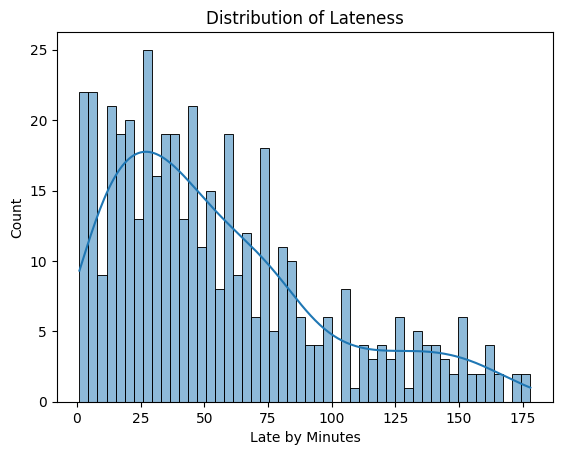

In [110]:
'''
Probably should remove 2021 - 2022 as it stil has effect of COVID restriction

DTTM is the arrival time
each train ID-date is unique
Deviation code: A- ahead, L-Late
'''

df = pd.read_csv('RMR_AllArrivals2.csv', on_bad_lines='skip', encoding='cp1252')

rocky_dat = (
    pd.read_csv('RMR_AllArrivals2.csv', on_bad_lines='skip', encoding='cp1252')
    .rename(columns={"SCHD_DEVN_MN": "Deviation minutes", "FINAL STATION":"final_station", "DT/TIME AT DEST":"arrival_time", 
                     "SCHD_DEVN_CD":"deviation_code"})
    .assign(date_actual=lambda x: pd.to_datetime(x["TRN_SCH_DPT_DT"]))
    .assign(year=lambda x: x["date_actual"].dt.year)
    .assign(month = lambda x: x["date_actual"].dt.month)
    .assign(day = lambda x: x["date_actual"].dt.day)
    .assign(merged_train=lambda x: 
            x['TRN_TYPE'].astype(str) + "-" + x['TRN_SYM'].astype(str) + "-" + x['TRN_SECT'].astype(str) +"-" + x['final_station'].str.strip())
    .assign(hours_late=lambda x: x['Deviation minutes'] / 60)
    .assign(
        arrival_status=lambda x: x['Deviation minutes'].apply(
            lambda minutes: (
                "late_90" if minutes == 180 else
                "late_60" if minutes >= 150 else
                "late_30" if minutes >= 120 else
                "late" if minutes >= 90 else
                "on_time"
            )
        )
    )
    .assign(
        arrival_status2=lambda x: x['Deviation minutes'].apply(
            lambda minutes: (
                #"late_180" if minutes >= 180 else
                "late_150" if minutes >= 150 else
                "late_120" if minutes >= 120 else
                "late_90" if minutes >= 90 else
                "late_60" if minutes >= 60 else
                #"late_30" if minutes >= 30 else
                "on_time"
            )
        )
    )
    .assign(
        arrival_status=lambda x: np.where(
            x['deviation_code'] == "A", "on_time", x['arrival_status']
        ),
        arrival_status2=lambda x: np.where(
            x['deviation_code'] == "A", "on_time", x['arrival_status2']
        )
    )


    .assign(
        rocky_penalties=lambda x: x.apply(
            lambda row: (30000 + ((row['Deviation minutes'] - 90) // 30) * 10000)
            if row['Deviation minutes'] >= 90 else 0, axis=1
        )
    )

    .assign(
        rocky_penalties = lambda x: np.where(
            x['deviation_code'] == 'A',  0, x['rocky_penalties']
        )
    )

    ## Removing rows where 'Deviation minutes' > 180
    .loc[lambda x: x['Deviation minutes'] <= 180]
    .loc[:, ["merged_train", "date_actual","year", "month", "day","deviation_code", "Deviation minutes", "rocky_penalties", 
             "arrival_status","arrival_status2","arrival_time", "final_station"]]
)

df_sum = (rocky_dat.loc[:, ['year', 'month', 'deviation_code', 'arrival_status2']]
               .groupby(['year', 'month']).size()
               .reset_index(name = 'train_count')
               .sort_values(['year', 'month'])
     )

df_status = (
    rocky_dat.loc[:, ['year', 'month', 'deviation_code', 'arrival_status2']]
    .groupby(['year', 'month', 'arrival_status2']).size()
    .unstack('arrival_status2')
    .fillna(0)
    .astype(int)
    .reset_index()
)


merged_df = (pd
          .merge(df_sum, df_status, on=['year', 'month'], how='inner')
          .rename(columns = {
              'late_150': 'over 150 mins late',
              'late_120': '120 - 150 mins late',
              'late_90': '90 - 120 mins late',
              'late_60' : '60 - 90 mins late',
              'on_time' : 'On Time'
          })
         
         )
merged_df.to_csv('rmr_late_status_monthly.csv', index = False)
display(merged_df)


rocky_late = rocky_dat.loc[rocky_dat['deviation_code'] == 'L']
plt.title("Distribution of Lateness")
plt.xlabel("Late by Minutes")
plt.ylabel("Count")
sns.histplot(rocky_late["Deviation minutes"], bins = 50, kde = True)



## Applying Client Penalty Model


In [89]:
penalty_unique = rocky_dat[["arrival_status", "rocky_penalties"]].drop_duplicates().reset_index(drop =True)

'''
Summary table grouped year and arrival status
'''
arrival_df = (
    rocky_dat.groupby(["year", "arrival_status"])
    .size()  # Get count of occurrences
    .to_frame(name="count")  # Convert to DataFrame and name the column
    .assign(percentage=lambda x: (x["count"] / x["count"].groupby(level=0).sum()) * 100)
    .reset_index()
    .merge(penalty_unique, on = "arrival_status", how ="left")
    .sort_values(["year", "arrival_status"], ascending = True)
)
cost_arrival_df = (rocky_dat.groupby(["year", "arrival_status"])["rocky_penalties"]
                   .sum()
                   .reset_index(name = "total_cost")
                  )

arrival_df = arrival_df.merge(cost_arrival_df, on=["year", "arrival_status"], how="left")


count_per_year = (
    rocky_dat.groupby("year")
    .size()
    .reset_index(name = "count")
)
ave_train_count = round(count_per_year["count"].mean(),0)
print(ave_train_count)
display(arrival_df)

120.0


,year,arrival_status,count,percentage,rocky_penalties,total_cost
0,2017,late,14,9.93,30000,420000
1,2017,late_30,10,7.09,40000,400000
2,2017,late_60,4,2.84,50000,200000
3,2017,on_time,113,80.14,0,0
4,2018,late,2,1.34,30000,60000
5,2018,late_30,1,0.67,40000,40000
6,2018,late_60,5,3.36,50000,250000
7,2018,on_time,141,94.63,0,0
8,2019,late,7,3.93,30000,210000
9,2019,late_30,9,5.06,40000,360000


In [90]:
'''
Expected penalty per train

treating the % of train in each late category as probability of a train being late in that category,
the result is the expected value of a penalty on each train.
'''
expected_count = (arrival_df
                    .groupby("year")['count'].sum()
                    .reset_index(name = "total_train")
                )
expected_penalty = (arrival_df
                    .groupby("year")
                    .apply(lambda year: (year["rocky_penalties"] * year["percentage"] / 100).sum())
                    .reset_index(name = "expected_penalty_per_train")
                    .merge(expected_count, on = ['year'], how = 'left')
                    .assign(expected_cost = lambda x: x['expected_penalty_per_train'] * x['total_train'])
                )



print(expected_penalty)



   year  expected_penalty_per_train  total_train  expected_cost
0  2017                     7234.04          141     1020000.00
1  2018                     2348.99          149      350000.00
2  2019                     4044.94          178      720000.00
3  2021                     1081.08           37       40000.00
4  2022                     1333.33           75      100000.00
5  2023                     2560.00          125      320000.00
6  2024                     4621.21          132      610000.00


/tmp/ipykernel_63/431875863.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda year: (year["rocky_penalties"] * year["percentage"] / 100).sum())


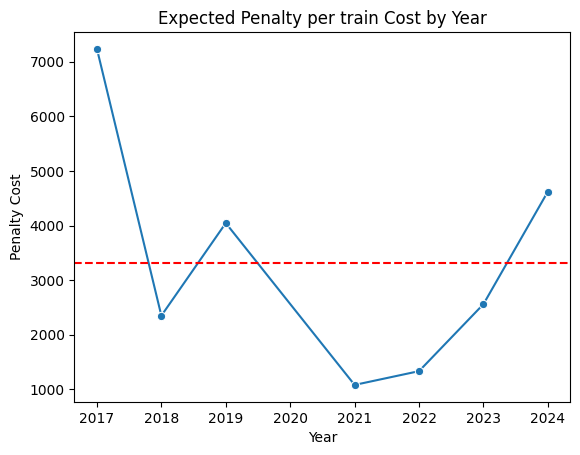

In [91]:
sns.lineplot(data=expected_penalty, x='year', y='expected_penalty_per_train', marker = 'o')
ave_val  =expected_penalty['expected_penalty_per_train'].mean()

plt.title("Expected Penalty per train Cost by Year")
plt.xlabel("Year")
plt.ylabel("Penalty Cost")
plt.axhline(y=ave_val, color='r', linestyle='--', label=f'Average: {ave_val:.2f}')

plt.show()

In [92]:
'''
Total Cost of penalties from past late trains
'''
print(arrival_df)
print("Total penalized cost per year")
past_penalties = (arrival_df
                  .groupby("year")["total_cost"]
                  .sum()
                  .reset_index(name = 'total_cost')
                 ) 
print(past_penalties)

    year arrival_status  count  percentage  rocky_penalties  total_cost
0   2017           late     14        9.93            30000      420000
1   2017        late_30     10        7.09            40000      400000
2   2017        late_60      4        2.84            50000      200000
3   2017        on_time    113       80.14                0           0
4   2018           late      2        1.34            30000       60000
5   2018        late_30      1        0.67            40000       40000
6   2018        late_60      5        3.36            50000      250000
7   2018        on_time    141       94.63                0           0
8   2019           late      7        3.93            30000      210000
9   2019        late_30      9        5.06            40000      360000
10  2019        late_60      3        1.69            50000      150000
11  2019        on_time    159       89.33                0           0
12  2021        late_30      1        2.70            40000     

# 2.2 : Naive (Mean) 2025 Client Model Penalty Prediction 


In [93]:
'''
Prediction of 2025 using mean of previous year
'''

expected_count = (arrival_df
                 .groupby("arrival_status")["count"]
                 .mean()
                 .reset_index()
                 .loc[:, ["arrival_status", "count"]]
                 .merge(penalty_unique, on = ["arrival_status"], how = "left")
                )

std_count = (arrival_df
                 .groupby("arrival_status")["count"]
                 .std()
                 .reset_index(name = "std_count")
                 .loc[:, ["arrival_status", "std_count"]]
                 .merge(penalty_unique, on = ["arrival_status"], how = "left")
                )

std_prob = (arrival_df
                 .groupby("arrival_status")["percentage"]
                 .std()
                 .reset_index(name = "std_perc")
                 .loc[:, ["arrival_status", "std_perc"]]
                 .merge(penalty_unique, on = ["arrival_status"], how = "left")
                )

print(expected_count)
print(std_count)
print(std_prob)
expected_prob = (arrival_df
                 .groupby("arrival_status")["percentage"]
                 .mean()
                 .reset_index()
                 .loc[:, ["arrival_status", "percentage"]]
                 .merge(penalty_unique, on = ["arrival_status"], how = "left")
                )
expected_cost_pred = (expected_prob["percentage"] * expected_prob["rocky_penalties"] / 100).sum()
print("2025 probabilities of train being late and it's corresponding penalties")
print(expected_prob)
print("Expected value of penalty per train ran")
print(expected_cost_pred)
print("Expected total cost of penalty")
expected_total = expected_cost_pred * ave_train_count
print(expected_total)

print("Expected incentive under VIA model")
on_time_perc = expected_prob.loc[expected_prob["arrival_status"] == "on_time", "percentage"].iloc[0]
print((on_time_perc - 85) * (0.02*5000000))




  arrival_status  count  rocky_penalties
0           late   6.40            30000
1        late_30   5.00            40000
2        late_60   3.33            50000
3        on_time 107.86                0
  arrival_status  std_count  rocky_penalties
0           late       4.72            30000
1        late_30       4.15            40000
2        late_60       1.03            50000
3        on_time      41.37                0
  arrival_status  std_perc  rocky_penalties
0           late      3.32            30000
1        late_30      2.47            40000
2        late_60      0.56            50000
3        on_time      6.17                0
2025 probabilities of train being late and it's corresponding penalties
  arrival_status  percentage  rocky_penalties
0           late        4.43            30000
1        late_30        3.74            40000
2        late_60        2.54            50000
3        on_time       91.46                0
Expected value of penalty per train ran
4092.095

90 mins late total cost: 960000
120 mins late total cost: 1200000
150 mins late total cost: 1000000
ave percentage of train being 90 mins late: 4.4298797416993
ave percentage of train being 120 mins late: 3.737542050361918
ave percentage of train being 150 mins late: 2.5362285547386
    year arrival_status  count  percentage  rocky_penalties  total_cost
2   2017        late_60      4        2.84            50000      200000
6   2018        late_60      5        3.36            50000      250000
10  2019        late_60      3        1.69            50000      150000
14  2022        late_60      2        2.67            50000      100000
18  2023        late_60      3        2.40            50000      150000
22  2024        late_60      3        2.27            50000      150000


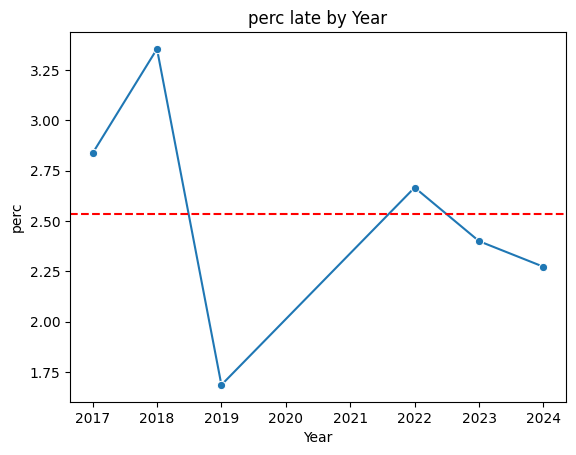

In [94]:
rocky_late = arrival_df.loc[arrival_df['arrival_status'] == 'late']
rocky_late30 = arrival_df.loc[arrival_df['arrival_status'] == 'late_30']
rocky_late60 = arrival_df.loc[arrival_df['arrival_status'] == 'late_60']

print("90 mins late total cost: {0}".format(rocky_late['total_cost'].sum()))
print("120 mins late total cost: {0}".format(rocky_late30['total_cost'].sum()))
print("150 mins late total cost: {0}".format(rocky_late60['total_cost'].sum()))

print("ave percentage of train being 90 mins late: {0}".format(rocky_late['percentage'].mean()))
print("ave percentage of train being 120 mins late: {0}".format(rocky_late30['percentage'].mean()))
print("ave percentage of train being 150 mins late: {0}".format(rocky_late60['percentage'].mean()))

print(rocky_late60)
sns.lineplot(data=rocky_late60, x='year', y='percentage', marker = 'o')
ave_val  = rocky_late60['percentage'].mean()
# Add title and labels for clarity
plt.title("perc late by Year")
plt.xlabel("Year")
plt.ylabel("perc")
plt.axhline(y=ave_val, color='r', linestyle='--', label=f'Average: {ave_val:.2f}')


# Show the plot
plt.show()



# 2.3 : Distributed Model


## Functions

In [96]:
def generate_penalty_df(p, total_penalty=60000, num_blocks=6):
    penalties_raw = np.array([i**p for i in range(1, num_blocks + 1)])
    scaling_factor = total_penalty / penalties_raw.sum()
    penalties = penalties_raw * scaling_factor
    cumulative_penalties = np.cumsum(penalties)

    df = pd.DataFrame({
        "arrival_status2": [f"late_{(i-1) * 30}" for i in range(1, num_blocks + 1)],
        "Penalty": penalties,
        "Cumulative Penalty": cumulative_penalties,
        "p": p,  # Optional: track which exponent was used
        "total_penalty": total_penalty
    })
    return df

def lin_incentive(min_pct_ontime, max_pct_ontime, min_pct_inc, max_pct_inc, blocks):
    pct_ontime_scale = np.linspace(min_pct_ontime, max_pct_ontime, blocks)
    pct_incentive_scale = np.linspace(min_pct_inc, max_pct_inc, blocks)
    df = pd.DataFrame({
        'pct ontime' : pct_ontime_scale,
        'pct incentive' : pct_incentive_scale
    })
    return df
    

def apply_modified_penalty(df, penalty_col="Cumulative Penalty", status_col="arrival_status2", cutoff=["late_30"]):
    return df[penalty_col].where(~df[status_col].isin(cutoff), 0)

def compute_arrival_df(rocky_dat, exp_penalty_df, cutoff=["late_30"]):
    return (
        rocky_dat.groupby(["year", "arrival_status2"])
        .size()
        .to_frame(name="count")
        .assign(percentage=lambda x: (x["count"] / x["count"].groupby(level=0).sum()) * 100)
        .reset_index()
        .merge(exp_penalty_df, on="arrival_status2", how="left")
        .assign(modified_cumu_penalty=lambda x: apply_modified_penalty(x, cutoff=cutoff))
        .assign(modified_total_cost=lambda x: x["count"] * x["modified_cumu_penalty"])
        .sort_values(["year", "arrival_status2"])
        .fillna(exp_penalty_df['p'].iloc[0])
    )

def compute_expected_count(arrival_df, exp_penalty_df, cutoff=["late_30"]):
    return (
        arrival_df.groupby("arrival_status2")["count"]
        .mean()
        .reset_index()
        .merge(exp_penalty_df, on="arrival_status2", how="left")
        .assign(modified_cumu_penalty=lambda x: apply_modified_penalty(x, cutoff=cutoff))
        .assign(modified_total_cost=lambda x: x["count"] * x["modified_cumu_penalty"])
        .sort_values("arrival_status2")
        .fillna(0)
    )

def compute_std_count(arrival_df, exp_penalty_df):
    return (
        arrival_df.groupby("arrival_status2")["count"]
        .std()
        .reset_index(name="std_count")
        .merge(exp_penalty_df, on="arrival_status2", how="left")
    )

def compute_expected_prob(arrival_df, exp_penalty_df, cutoff=["late_30"]):
    return (
        arrival_df.groupby("arrival_status2")["percentage"]
        .mean()
        .reset_index(name="perc")
        .merge(exp_penalty_df, on="arrival_status2", how="left")
        .assign(modified_cumu_penalty=lambda x: apply_modified_penalty(x, cutoff=cutoff))
        .fillna(0)
    )

## Creating a dictionary of penalty models

In [97]:
penalty_dict = {}
p_values = range(1, 10)
total_penalty_values = range(10000, 70000, 10000)

# Example: Create a list of DataFrames for p from 1 to 6
for p in p_values:
    penalty_dict[p] = {}
    for total_penalty in total_penalty_values:
        penalty_dict[p][total_penalty] = generate_penalty_df(p, total_penalty)



## Creating a dictionary of linear incentive models

In [98]:
from itertools import product

min_pct_ontime = [90]
pct_ontime_range = 10
max_incentive = range(100000, 250000, 5000)
blocks = [3]

combinations = list(product(min_pct_ontime, max_incentive, blocks))
incentive_dict = {combo: None for combo in combinations}

'''
ontime threshold = 90
Max incentive : 100,000 - 200,000
distribute blocks = 3
'''
for combo in incentive_dict:
    min_pct_ontime, max_pct_inc, blocks = combo
    max_pct_ontime = min_pct_ontime + pct_ontime_range
    min_pct_inc = 0
    incentive_dict[combo] = lin_incentive(min_pct_ontime, max_pct_ontime, min_pct_inc, max_pct_inc, blocks)


#print(incentive_dict.keys())
## key: ontime_threshold, start incentive, blocks

def mapping_incentive(pct_df, incentive_df):
    # Sort just in case
    incentive_df = incentive_df.sort_values("pct ontime").reset_index(drop=True)
    
    # Create bin edges for "greater than threshold" logic
    thresholds = incentive_df["pct ontime"].tolist()
    
    # Shift thresholds down by one position to make each bin start from the *previous* threshold
    # e.g., thresholds [70, 80, 90] -> bins [0, 70, 80, 90]
    bins = [0] + thresholds
    
    # Labels should be for the next tier (i.e., skip the first incentive)
    labels = incentive_df["pct incentive"].tolist()
    
    # Ensure the length of labels matches the number of bins - 1
    if len(labels) != len(bins) - 1:
        labels = [0] + labels  # Add a 0 incentive for values below the first threshold

    percentages_series = pd.Series(pct_df)
    
    # Cut and map
    binned = pd.cut(percentages_series, bins=bins, labels=labels, right=False, include_lowest=True)
    
    # Handle any value >= the highest threshold
    max_incentive = incentive_df["pct incentive"].max()
    result = []
    for val, bin_val in zip(percentages_series, binned):
        if pd.isna(bin_val):
            result.append(max_incentive)
        else:
            result.append(bin_val)
    
    return result


print(incentive_dict[90, 100000, 3])
incentive_df = incentive_dict[90, 100000, 3]
print(mapping_incentive(list(range(80,100)), incentive_df))


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       50000.00
2      100.00      100000.00
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50000.0, 50000.0, 50000.0, 50000.0, 50000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]


## Parameterized Distributed Model

In [99]:
pd.set_option('display.float_format', '{:.2f}'.format)

custom_exp_penalty = pd.DataFrame({
    'arrival_status2': ['late_0', 'late_30', 'late_60', 'late_90', 'late_120', 'late_150'],
    'Penalty' : [0, 0, 500, 2000, 5000, 10000],
    'p' : ['~4'] * 6,
    'Cumulative Penalty': [0, 0, 500, 2000, 5000, 10000],
    'total_penalty': [10000] * 6
})
exp_penalty = custom_exp_penalty
print(incentive_dict.keys())
incentive_df = incentive_dict[90, 100000, 3]



## Creating Arrival df with the given penalty model
arrival_df2 = (
    rocky_dat.groupby(["year", "arrival_status2"])
    .size()  
    .to_frame(name="count")  
    .assign(percentage=lambda x: (x["count"] / x["count"].groupby(level=0).sum()) * 100)
    .reset_index()
    .merge(exp_penalty, on = "arrival_status2", how ="left")
    
    ## setting 0 - 60 mins categories as 0 penalty
    .assign(modified_cumu_penalty=lambda x: 
            x["Cumulative Penalty"].where(~x["arrival_status2"].isin(["late_30"]), 0)
           )
    .assign(modified_total_cost = lambda x: x['count'] * x['modified_cumu_penalty'])    
    #.assign(total_cost = lambda x: x['Cumulative Penalty'] * x['count'])
    .sort_values(["year", "arrival_status2"], ascending = True)
    .fillna(0)
)



#print("Total penalized cost per year with distributed model")
past_penalties2 = (
    arrival_df2
    .groupby("year")['modified_total_cost'].sum()
    .reset_index(name = 'mod_total_cost')
)


#display(past_penalties2)

expected_count2025 = (arrival_df2
                 .groupby("arrival_status2")["count"]
                 .mean()
                 .reset_index()
                 .loc[:, ["arrival_status2", "count"]]
                 .merge(exp_penalty, on = ["arrival_status2"], how = "left")
                 .fillna(0)
                 .sort_values(["arrival_status2"], ascending = True)
                 .assign(total_cost =lambda x: x['count'] * x['Cumulative Penalty'])
                   
                 # penalty only applied after 90 mins late
                 .assign(modified_cumu_penalty=lambda x: 
                    x["Cumulative Penalty"].where(~x["arrival_status2"].isin(["late_30"]), 0)
                        )

                 .assign(modified_total_cost = lambda x: x['count'] * x['modified_cumu_penalty'])
                   
                
)

std_count2025 = (arrival_df2
                 .groupby("arrival_status2")["count"]
                 .std()
                 .reset_index(name = "std_count")
                 .loc[:, ["arrival_status2", "std_count"]]
                 .merge(exp_penalty, on = ["arrival_status2"], how = "left")
                )

## project for 2025
expected_prob2025 = (arrival_df2
                 .groupby("arrival_status2")["percentage"]
                 .mean()
                 .reset_index(name = "perc")
                 .loc[:, ["arrival_status2", "perc"]]
                 .merge(exp_penalty, on = ["arrival_status2"], how = "left")
                 .assign(modified_cumu_penalty=lambda x: 
                    x["Cumulative Penalty"].where(~x["arrival_status2"].isin(["late_30"]), 0)
                        )
                 .fillna(0)
                )

expected_cost_pred2025 = (expected_prob2025["perc"] * expected_prob2025["modified_cumu_penalty"] / 100).sum()
ave_train_count2025 = expected_count2025['count'].sum()
#display(expected_prob2025)
#display(expected_count2025)
print("2025 probabilities of train being late and it's corresponding penalties - distributed")
print(expected_cost_pred2025)
print(expected_cost_pred2025 * ave_train_count2025)


## creating expected value
past_expected_penalty2 = (arrival_df2
                    .groupby("year")
                    .apply(lambda year: (year["modified_cumu_penalty"] * year["percentage"] / 100).sum())
                    .reset_index(name = "expected_penalty_per_train")
                )


## counting the total trains per year
past_count = (arrival_df2
                    .groupby("year")['count']
                    .sum()
                    .reset_index(name = "count of trains")
                )

# Revenue values per year
revenue_map = {
    2017: 4055459,
    2018: 6677257,
    2019: 4185566,
    2021: 1728305,
    2022: 4064163,
    2023: 6113531,
    2024: 3876571
}

## calculating the % if train on time
on_time_pct = (
    arrival_df2[arrival_df2["arrival_status2"].isin(["on_time", "late_30", "late_60"])]
    .groupby("year")["percentage"]
    .sum()
    .reset_index(name="on_time_pct")
)


# Final table with all columns
# Final summary including on_time_pct
past_expected_cost = (
    past_expected_penalty2
    
    ## merging with count of trains per year
    .merge(past_count, on="year", how="left")
    .assign(
        total_revenue = lambda x: x["year"].map(revenue_map),
        expected_cost = lambda x: x["expected_penalty_per_train"] * x["count of trains"],
        revenue_per_train = lambda x: x["total_revenue"] / x["count of trains"],
        overall_penalty_pct = lambda x: (x["expected_cost"] / x["total_revenue"]) * 100
    )
    
    ## merge with % of train on time
    .merge(on_time_pct, on="year", how="left")
    .assign(
        incentive_pct = lambda x: mapping_incentive(
            x["on_time_pct"], incentive_df
        )
    )
    .assign(
        incentive_value = lambda x: x['incentive_pct']
    )
    .assign(
        net_value = lambda x: x['incentive_value'] - x['expected_cost']
    )
    .loc[:, [
        "year",
        "count of trains",
        "total_revenue",
        "revenue_per_train",
        "expected_cost",
        "expected_penalty_per_train",
        "overall_penalty_pct",
        "on_time_pct",
        "incentive_pct",
        "incentive_value",
        "net_value"
    ]]
)

# Get the base DataFrame once
base_df = past_expected_cost.loc[:, [
    "year",
    "expected_cost",
    "on_time_pct"
]]
expected_cost_2025 = expected_cost_pred2025 * ave_train_count
revenue_per_train_2025 = 5000000/ave_train_count
overall_penalty_pct_2025 = expected_cost_pred2025 / revenue_per_train_2025 * 100
incentive_pct_2025 = mapping_incentive(80, incentive_df)[0]

# Create an empty list to collect results
incentive_lst = []
#print(mapping_incentive(base_df['on_time_pct'], incentive_df))
# Loop through the incentive_dict and process
#print(base_df)
base_df = base_df.assign(incentive_value = lambda x: mapping_incentive(
                x['on_time_pct'], incentive_df)
               )

print(base_df)
for key, incentive_df in incentive_dict.items():
    #print(key)
    #print(incentive_df)
    df_with_incentive = (
        base_df
        .assign(
            incentive_value=lambda x: mapping_incentive(
                x['on_time_pct'], incentive_df
            )
        )
        #.pipe(lambda df: print(f"\nProcessed: {key}\n", df) or df)
        .assign(
            net_val=lambda x: x['incentive_value'] - x['expected_cost']
        )
        .assign(name=[key] * len(base_df))

    )
    


    incentive_value_2025 = mapping_incentive(80, incentive_df)[0]
    net_value_2025 = incentive_value_2025 - expected_cost_2025
    df_2025 = pd.DataFrame({
        'year': [2025],
        'count of trains': [ave_train_count],
        'total_revenue': [5000000],
        'revenue_per_train': [revenue_per_train_2025],
        'expected_cost': [expected_cost_2025],
        'expected_penalty_per_train': [expected_cost_pred2025],
        'overall_penalty_pct': [overall_penalty_pct_2025],
        'on_time_pct': [80.18],
        'incentive_pct': [incentive_pct_2025],
        'incentive_value': [incentive_value_2025],
        'net_val': [net_value_2025]
    })
    df_2025 = df_2025.loc[:, ["year", "expected_cost", "incentive_value","on_time_pct", "net_val"]]

    final_df = pd.concat([df_with_incentive, df_2025], ignore_index=True)
    incentive_lst.append(final_df)

#display(arrival_df2)
#print(past_expected_cost['overall_penalty_pct'].mean())
#print(exp_penalty)
#print(incentive_df)

#display(arrival_df2)

for i in incentive_lst:
    display(i)
    inc_name = i['name'][0]
    print(incentive_dict[inc_name])


dict_keys([(90, 100000, 3), (90, 105000, 3), (90, 110000, 3), (90, 115000, 3), (90, 120000, 3), (90, 125000, 3), (90, 130000, 3), (90, 135000, 3), (90, 140000, 3), (90, 145000, 3), (90, 150000, 3), (90, 155000, 3), (90, 160000, 3), (90, 165000, 3), (90, 170000, 3), (90, 175000, 3), (90, 180000, 3), (90, 185000, 3), (90, 190000, 3), (90, 195000, 3), (90, 200000, 3), (90, 205000, 3), (90, 210000, 3), (90, 215000, 3), (90, 220000, 3), (90, 225000, 3), (90, 230000, 3), (90, 235000, 3), (90, 240000, 3), (90, 245000, 3)])
2025 probabilities of train being late and it's corresponding penalties - distributed
585.0059156295148
71716.15377126775
   year  expected_cost  on_time_pct  incentive_value
0  2017      129000.00        80.14             0.00
1  2018       64000.00        94.63         50000.00
2  2019       95000.00        89.33             0.00
3  2021        8500.00        97.30        100000.00
4  2022       25000.00        97.33        100000.00
5  2023       49500.00        93.60   

/tmp/ipykernel_63/92348513.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda year: (year["modified_cumu_penalty"] * year["percentage"] / 100).sum())


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 100000, 3)"
1,2018,64000.00,94.63,50000.00,-14000.00,"(90, 100000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 100000, 3)"
3,2021,8500.00,97.30,100000.00,91500.00,"(90, 100000, 3)"
4,2022,25000.00,97.33,100000.00,75000.00,"(90, 100000, 3)"
5,2023,49500.00,93.60,50000.00,500.00,"(90, 100000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 100000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       50000.00
2      100.00      100000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 105000, 3)"
1,2018,64000.00,94.63,52500.00,-11500.00,"(90, 105000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 105000, 3)"
3,2021,8500.00,97.30,105000.00,96500.00,"(90, 105000, 3)"
4,2022,25000.00,97.33,105000.00,80000.00,"(90, 105000, 3)"
5,2023,49500.00,93.60,52500.00,3000.00,"(90, 105000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 105000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       52500.00
2      100.00      105000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 110000, 3)"
1,2018,64000.00,94.63,55000.00,-9000.00,"(90, 110000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 110000, 3)"
3,2021,8500.00,97.30,110000.00,101500.00,"(90, 110000, 3)"
4,2022,25000.00,97.33,110000.00,85000.00,"(90, 110000, 3)"
5,2023,49500.00,93.60,55000.00,5500.00,"(90, 110000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 110000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       55000.00
2      100.00      110000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 115000, 3)"
1,2018,64000.00,94.63,57500.00,-6500.00,"(90, 115000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 115000, 3)"
3,2021,8500.00,97.30,115000.00,106500.00,"(90, 115000, 3)"
4,2022,25000.00,97.33,115000.00,90000.00,"(90, 115000, 3)"
5,2023,49500.00,93.60,57500.00,8000.00,"(90, 115000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 115000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       57500.00
2      100.00      115000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 120000, 3)"
1,2018,64000.00,94.63,60000.00,-4000.00,"(90, 120000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 120000, 3)"
3,2021,8500.00,97.30,120000.00,111500.00,"(90, 120000, 3)"
4,2022,25000.00,97.33,120000.00,95000.00,"(90, 120000, 3)"
5,2023,49500.00,93.60,60000.00,10500.00,"(90, 120000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 120000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       60000.00
2      100.00      120000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 125000, 3)"
1,2018,64000.00,94.63,62500.00,-1500.00,"(90, 125000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 125000, 3)"
3,2021,8500.00,97.30,125000.00,116500.00,"(90, 125000, 3)"
4,2022,25000.00,97.33,125000.00,100000.00,"(90, 125000, 3)"
5,2023,49500.00,93.60,62500.00,13000.00,"(90, 125000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 125000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       62500.00
2      100.00      125000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 130000, 3)"
1,2018,64000.00,94.63,65000.00,1000.00,"(90, 130000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 130000, 3)"
3,2021,8500.00,97.30,130000.00,121500.00,"(90, 130000, 3)"
4,2022,25000.00,97.33,130000.00,105000.00,"(90, 130000, 3)"
5,2023,49500.00,93.60,65000.00,15500.00,"(90, 130000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 130000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       65000.00
2      100.00      130000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 135000, 3)"
1,2018,64000.00,94.63,67500.00,3500.00,"(90, 135000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 135000, 3)"
3,2021,8500.00,97.30,135000.00,126500.00,"(90, 135000, 3)"
4,2022,25000.00,97.33,135000.00,110000.00,"(90, 135000, 3)"
5,2023,49500.00,93.60,67500.00,18000.00,"(90, 135000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 135000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       67500.00
2      100.00      135000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 140000, 3)"
1,2018,64000.00,94.63,70000.00,6000.00,"(90, 140000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 140000, 3)"
3,2021,8500.00,97.30,140000.00,131500.00,"(90, 140000, 3)"
4,2022,25000.00,97.33,140000.00,115000.00,"(90, 140000, 3)"
5,2023,49500.00,93.60,70000.00,20500.00,"(90, 140000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 140000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       70000.00
2      100.00      140000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 145000, 3)"
1,2018,64000.00,94.63,72500.00,8500.00,"(90, 145000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 145000, 3)"
3,2021,8500.00,97.30,145000.00,136500.00,"(90, 145000, 3)"
4,2022,25000.00,97.33,145000.00,120000.00,"(90, 145000, 3)"
5,2023,49500.00,93.60,72500.00,23000.00,"(90, 145000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 145000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       72500.00
2      100.00      145000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 150000, 3)"
1,2018,64000.00,94.63,75000.00,11000.00,"(90, 150000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 150000, 3)"
3,2021,8500.00,97.30,150000.00,141500.00,"(90, 150000, 3)"
4,2022,25000.00,97.33,150000.00,125000.00,"(90, 150000, 3)"
5,2023,49500.00,93.60,75000.00,25500.00,"(90, 150000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 150000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       75000.00
2      100.00      150000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 155000, 3)"
1,2018,64000.00,94.63,77500.00,13500.00,"(90, 155000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 155000, 3)"
3,2021,8500.00,97.30,155000.00,146500.00,"(90, 155000, 3)"
4,2022,25000.00,97.33,155000.00,130000.00,"(90, 155000, 3)"
5,2023,49500.00,93.60,77500.00,28000.00,"(90, 155000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 155000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       77500.00
2      100.00      155000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 160000, 3)"
1,2018,64000.00,94.63,80000.00,16000.00,"(90, 160000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 160000, 3)"
3,2021,8500.00,97.30,160000.00,151500.00,"(90, 160000, 3)"
4,2022,25000.00,97.33,160000.00,135000.00,"(90, 160000, 3)"
5,2023,49500.00,93.60,80000.00,30500.00,"(90, 160000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 160000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       80000.00
2      100.00      160000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 165000, 3)"
1,2018,64000.00,94.63,82500.00,18500.00,"(90, 165000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 165000, 3)"
3,2021,8500.00,97.30,165000.00,156500.00,"(90, 165000, 3)"
4,2022,25000.00,97.33,165000.00,140000.00,"(90, 165000, 3)"
5,2023,49500.00,93.60,82500.00,33000.00,"(90, 165000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 165000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       82500.00
2      100.00      165000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 170000, 3)"
1,2018,64000.00,94.63,85000.00,21000.00,"(90, 170000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 170000, 3)"
3,2021,8500.00,97.30,170000.00,161500.00,"(90, 170000, 3)"
4,2022,25000.00,97.33,170000.00,145000.00,"(90, 170000, 3)"
5,2023,49500.00,93.60,85000.00,35500.00,"(90, 170000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 170000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       85000.00
2      100.00      170000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 175000, 3)"
1,2018,64000.00,94.63,87500.00,23500.00,"(90, 175000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 175000, 3)"
3,2021,8500.00,97.30,175000.00,166500.00,"(90, 175000, 3)"
4,2022,25000.00,97.33,175000.00,150000.00,"(90, 175000, 3)"
5,2023,49500.00,93.60,87500.00,38000.00,"(90, 175000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 175000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       87500.00
2      100.00      175000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 180000, 3)"
1,2018,64000.00,94.63,90000.00,26000.00,"(90, 180000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 180000, 3)"
3,2021,8500.00,97.30,180000.00,171500.00,"(90, 180000, 3)"
4,2022,25000.00,97.33,180000.00,155000.00,"(90, 180000, 3)"
5,2023,49500.00,93.60,90000.00,40500.00,"(90, 180000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 180000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       90000.00
2      100.00      180000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 185000, 3)"
1,2018,64000.00,94.63,92500.00,28500.00,"(90, 185000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 185000, 3)"
3,2021,8500.00,97.30,185000.00,176500.00,"(90, 185000, 3)"
4,2022,25000.00,97.33,185000.00,160000.00,"(90, 185000, 3)"
5,2023,49500.00,93.60,92500.00,43000.00,"(90, 185000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 185000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       92500.00
2      100.00      185000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 190000, 3)"
1,2018,64000.00,94.63,95000.00,31000.00,"(90, 190000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 190000, 3)"
3,2021,8500.00,97.30,190000.00,181500.00,"(90, 190000, 3)"
4,2022,25000.00,97.33,190000.00,165000.00,"(90, 190000, 3)"
5,2023,49500.00,93.60,95000.00,45500.00,"(90, 190000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 190000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       95000.00
2      100.00      190000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 195000, 3)"
1,2018,64000.00,94.63,97500.00,33500.00,"(90, 195000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 195000, 3)"
3,2021,8500.00,97.30,195000.00,186500.00,"(90, 195000, 3)"
4,2022,25000.00,97.33,195000.00,170000.00,"(90, 195000, 3)"
5,2023,49500.00,93.60,97500.00,48000.00,"(90, 195000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 195000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00       97500.00
2      100.00      195000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 200000, 3)"
1,2018,64000.00,94.63,100000.00,36000.00,"(90, 200000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 200000, 3)"
3,2021,8500.00,97.30,200000.00,191500.00,"(90, 200000, 3)"
4,2022,25000.00,97.33,200000.00,175000.00,"(90, 200000, 3)"
5,2023,49500.00,93.60,100000.00,50500.00,"(90, 200000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 200000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      100000.00
2      100.00      200000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 205000, 3)"
1,2018,64000.00,94.63,102500.00,38500.00,"(90, 205000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 205000, 3)"
3,2021,8500.00,97.30,205000.00,196500.00,"(90, 205000, 3)"
4,2022,25000.00,97.33,205000.00,180000.00,"(90, 205000, 3)"
5,2023,49500.00,93.60,102500.00,53000.00,"(90, 205000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 205000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      102500.00
2      100.00      205000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 210000, 3)"
1,2018,64000.00,94.63,105000.00,41000.00,"(90, 210000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 210000, 3)"
3,2021,8500.00,97.30,210000.00,201500.00,"(90, 210000, 3)"
4,2022,25000.00,97.33,210000.00,185000.00,"(90, 210000, 3)"
5,2023,49500.00,93.60,105000.00,55500.00,"(90, 210000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 210000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      105000.00
2      100.00      210000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 215000, 3)"
1,2018,64000.00,94.63,107500.00,43500.00,"(90, 215000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 215000, 3)"
3,2021,8500.00,97.30,215000.00,206500.00,"(90, 215000, 3)"
4,2022,25000.00,97.33,215000.00,190000.00,"(90, 215000, 3)"
5,2023,49500.00,93.60,107500.00,58000.00,"(90, 215000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 215000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      107500.00
2      100.00      215000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 220000, 3)"
1,2018,64000.00,94.63,110000.00,46000.00,"(90, 220000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 220000, 3)"
3,2021,8500.00,97.30,220000.00,211500.00,"(90, 220000, 3)"
4,2022,25000.00,97.33,220000.00,195000.00,"(90, 220000, 3)"
5,2023,49500.00,93.60,110000.00,60500.00,"(90, 220000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 220000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      110000.00
2      100.00      220000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 225000, 3)"
1,2018,64000.00,94.63,112500.00,48500.00,"(90, 225000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 225000, 3)"
3,2021,8500.00,97.30,225000.00,216500.00,"(90, 225000, 3)"
4,2022,25000.00,97.33,225000.00,200000.00,"(90, 225000, 3)"
5,2023,49500.00,93.60,112500.00,63000.00,"(90, 225000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 225000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      112500.00
2      100.00      225000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 230000, 3)"
1,2018,64000.00,94.63,115000.00,51000.00,"(90, 230000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 230000, 3)"
3,2021,8500.00,97.30,230000.00,221500.00,"(90, 230000, 3)"
4,2022,25000.00,97.33,230000.00,205000.00,"(90, 230000, 3)"
5,2023,49500.00,93.60,115000.00,65500.00,"(90, 230000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 230000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      115000.00
2      100.00      230000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 235000, 3)"
1,2018,64000.00,94.63,117500.00,53500.00,"(90, 235000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 235000, 3)"
3,2021,8500.00,97.30,235000.00,226500.00,"(90, 235000, 3)"
4,2022,25000.00,97.33,235000.00,210000.00,"(90, 235000, 3)"
5,2023,49500.00,93.60,117500.00,68000.00,"(90, 235000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 235000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      117500.00
2      100.00      235000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 240000, 3)"
1,2018,64000.00,94.63,120000.00,56000.00,"(90, 240000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 240000, 3)"
3,2021,8500.00,97.30,240000.00,231500.00,"(90, 240000, 3)"
4,2022,25000.00,97.33,240000.00,215000.00,"(90, 240000, 3)"
5,2023,49500.00,93.60,120000.00,70500.00,"(90, 240000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 240000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      120000.00
2      100.00      240000.00


,year,expected_cost,on_time_pct,incentive_value,net_val,name
0,2017,129000.00,80.14,0.00,-129000.00,"(90, 245000, 3)"
1,2018,64000.00,94.63,122500.00,58500.00,"(90, 245000, 3)"
2,2019,95000.00,89.33,0.00,-95000.00,"(90, 245000, 3)"
3,2021,8500.00,97.30,245000.00,236500.00,"(90, 245000, 3)"
4,2022,25000.00,97.33,245000.00,220000.00,"(90, 245000, 3)"
5,2023,49500.00,93.60,122500.00,73000.00,"(90, 245000, 3)"
6,2024,84500.00,87.88,0.00,-84500.00,"(90, 245000, 3)"
7,2025,70200.71,80.18,0.00,-70200.71,NaN


   pct ontime  pct incentive
0       90.00           0.00
1       95.00      122500.00
2      100.00      245000.00


# 2.1 : Linear Model Predicting percentage of on-time for 2025

0   64.54
1   87.92
2   82.58
3   78.38
4   84.00
5   88.00
6   76.52
Name: on_time_pct, dtype: float64

Optimal α: 0.60, Minimum MSE: 101.19
Predicted on-time percentage for next year: 80.18%


/home/daiweiliu112/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/daiweiliu112/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/daiweiliu112/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/daiweiliu112/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/daiweiliu112/.local/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning

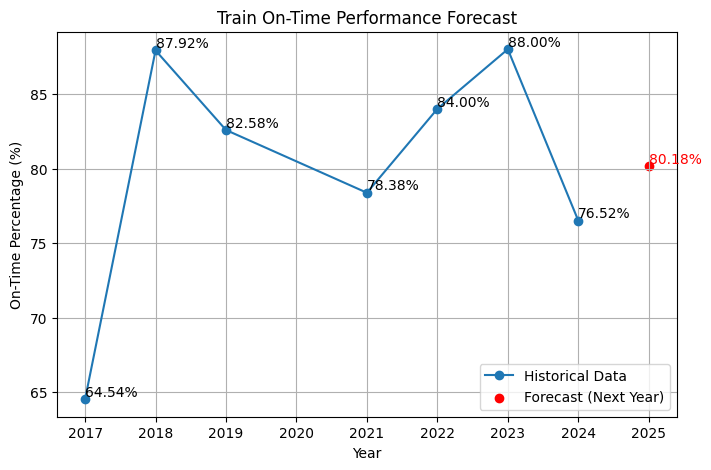

In [100]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

on_time_pct = (
    arrival_df2[arrival_df2["arrival_status2"].isin(["on_time", "late_30"])]
    .groupby("year")["percentage"]
    .sum()
    .reset_index(name="on_time_pct")
)
data = on_time_pct["on_time_pct"]
display(data)

# Range of alpha values
alpha_values = np.linspace(0.1, 1.0, 10)  # Test values from 0.1 to 1.0

best_alpha = None
best_mse = float("inf")

for alpha in alpha_values:
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha)
    predictions = model.fittedvalues  # In-sample predictions
    mse = mean_squared_error(data, predictions)

    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

print(f"Optimal α: {best_alpha:.2f}, Minimum MSE: {best_mse:.2f}")



model = SimpleExpSmoothing(on_time_pct["on_time_pct"]).fit(smoothing_level=best_alpha)  
predicted_next_year = model.forecast(1)
print(f"Predicted on-time percentage for next year: {predicted_next_year.iloc[0]:.2f}%")


# Plot historical data
plt.figure(figsize=(8, 5))
plt.plot(on_time_pct["year"], on_time_pct["on_time_pct"], marker='o', linestyle='-', label="Historical Data")

# Plot the forecast
future_year = on_time_pct["year"].iloc[-1] + 1  # Assuming index represents years
plt.scatter(future_year, predicted_next_year.iloc[0], color='red', label="Forecast (Next Year)")


# Add data labels for historical data
for x, y in zip(on_time_pct["year"], on_time_pct["on_time_pct"]):
    plt.text(x, y, f"{y:.2f}%", ha='left', va='bottom', fontsize=10)
# Add data label for forecasted point
plt.text(future_year, predicted_next_year.iloc[0], f"{predicted_next_year.iloc[0]:.2f}%", 
         ha='left', va='bottom', fontsize=10, color='red')

# Formatting
plt.xlabel("Year")
plt.ylabel("On-Time Percentage (%)")
plt.title("Train On-Time Performance Forecast")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [101]:
exp_penalty = penalty_dict[4][10000]
print(exp_penalty)
df_2025 = pd.DataFrame({
    'year': [2025],
    'count of trains': [ave_train_count],
    'total_revenue': [5000000],
    'revenue_per_train': [revenue_per_train_2025],
    'expected_cost': [expected_cost_2025],
    'expected_penalty_per_train': [expected_cost_pred2025],
    'overall_penalty_pct': [overall_penalty_pct_2025],
    'on_time_pct': [90],
    'incentive_pct': [incentive_pct_2025],
    'incentive_value': [incentive_value_2025],
    'net_value': [net_value_2025]
})

custom_exp_penalty = pd.DataFrame({
    'arrival_status2': ['late_0', 'late_30', 'late_60', 'late_90', 'late_120', 'late_150'],
    'Penalty' : [0, 0, 500, 2000, 5000, 10000],
    'p' : ['~4'] * 6,
    'Cumulative Penalty': [0, 0, 500, 2000, 5000, 100000],
    'total_penalty': [10000] * 6
})
print(custom_exp_penalty)

  arrival_status2  Penalty  Cumulative Penalty  p  total_penalty
0          late_0     4.40                4.40  4          10000
1         late_30    70.33               74.73  4          10000
2         late_60   356.04              430.77  4          10000
3         late_90  1125.27             1556.04  4          10000
4        late_120  2747.25             4303.30  4          10000
5        late_150  5696.70            10000.00  4          10000
  arrival_status2  Penalty   p  Cumulative Penalty  total_penalty
0          late_0        0  ~4                   0          10000
1         late_30        0  ~4                   0          10000
2         late_60      500  ~4                 500          10000
3         late_90     2000  ~4                2000          10000
4        late_120     5000  ~4                5000          10000
5        late_150    10000  ~4              100000          10000


## List of Dataframe for different P

In [102]:
penalty_dfs = []
for p in range(1,11):
    penalty_dfs.append(generate_penalty_df(p))

results_by_p = []
past_results_by_p = []
expected_cost = []


for penalty_df in penalty_dfs: 
    p = penalty_df["p"].iloc[0] if "p" in penalty_df.columns else None
    
    arrival_df = compute_arrival_df(rocky_dat, penalty_df)
    expected_count = compute_expected_count(arrival_df, penalty_df)
    std_count = compute_std_count(arrival_df, penalty_df)
    expected_prob = compute_expected_prob(arrival_df, penalty_df)

    ## Past Penalties 2017 - 2024 varied by P
    past_penalties_by_p = (
                        arrival_df
                        .groupby(["year", 'p'])['modified_total_cost'].sum()
                        .reset_index(name = 'mod_total_cost')
                        )

    past_results_by_p.append(past_penalties_by_p)

    ## 2025 Expected value varied by P
    expected_cost_pred = (expected_prob["perc"] * expected_prob["modified_cumu_penalty"] / 100).sum()
    expected_cost.append(round(expected_cost_pred,3))
    
#display(penalty_dfs)
expected_cost_df = (
    pd.DataFrame(expected_cost, columns=["expected_cost"])
    .assign(expected_cost = lambda x: x['expected_cost'] * ave_train_count)
    .assign(p=lambda x: x.index + 1)
)

# Display the DataFrame
print(expected_cost_df)
#display(past_results_by_p)

   expected_cost   p
0      756729.48   1
1      574260.48   2
2      457951.32   3
3      382722.12   4
4      332401.08   5
5      297532.32   6
6      272545.68   7
7      254089.80   8
8      240098.40   9
9      229261.80  10


In [103]:
# List of dataframes
dfs = penalty_dfs  # Replace with your actual list of DataFrames

# Iterate through the list of dataframes, remove first two rows, and display them
for idx, df in enumerate(dfs):
    # Remove the first two rows using iloc
    df_cleaned = df.iloc[2:].reset_index(drop=True)
    
    # Display the cleaned DataFrame
    print(f"### DataFrame {idx+1}")
    print(df_cleaned.to_markdown())
    print("\n")  # Add extra space between DataFrames




### DataFrame 1
|    | arrival_status2   |   Penalty |   Cumulative Penalty |   p |   total_penalty |
|---:|:------------------|----------:|---------------------:|----:|----------------:|
|  0 | late_60           |   8571.43 |              17142.9 |   1 |           60000 |
|  1 | late_90           |  11428.6  |              28571.4 |   1 |           60000 |
|  2 | late_120          |  14285.7  |              42857.1 |   1 |           60000 |
|  3 | late_150          |  17142.9  |              60000   |   1 |           60000 |


### DataFrame 2
|    | arrival_status2   |   Penalty |   Cumulative Penalty |   p |   total_penalty |
|---:|:------------------|----------:|---------------------:|----:|----------------:|
|  0 | late_60           |   5934.07 |              9230.77 |   2 |           60000 |
|  1 | late_90           |  10549.5  |             19780.2  |   2 |           60000 |
|  2 | late_120          |  16483.5  |             36263.7  |   2 |           60000 |
|  3 | late_150     

  arrival_status2  Penalty  Cumulative Penalty   p  total_penalty
0          late_0  2857.14             2857.14   1          60000
1         late_30  5714.29             8571.43   1          60000
2         late_60  8571.43            17142.86   1          60000
3         late_90 11428.57            28571.43   1          60000
4        late_120 14285.71            42857.14   1          60000
5        late_150 17142.86            60000.00   1          60000
0          late_0   659.34              659.34   2          60000
1         late_30  2637.36             3296.70   2          60000
2         late_60  5934.07             9230.77   2          60000
3         late_90 10549.45            19780.22   2          60000
4        late_120 16483.52            36263.74   2          60000
5        late_150 23736.26            60000.00   2          60000
0          late_0   136.05              136.05   3          60000
1         late_30  1088.44             1224.49   3          60000
2         

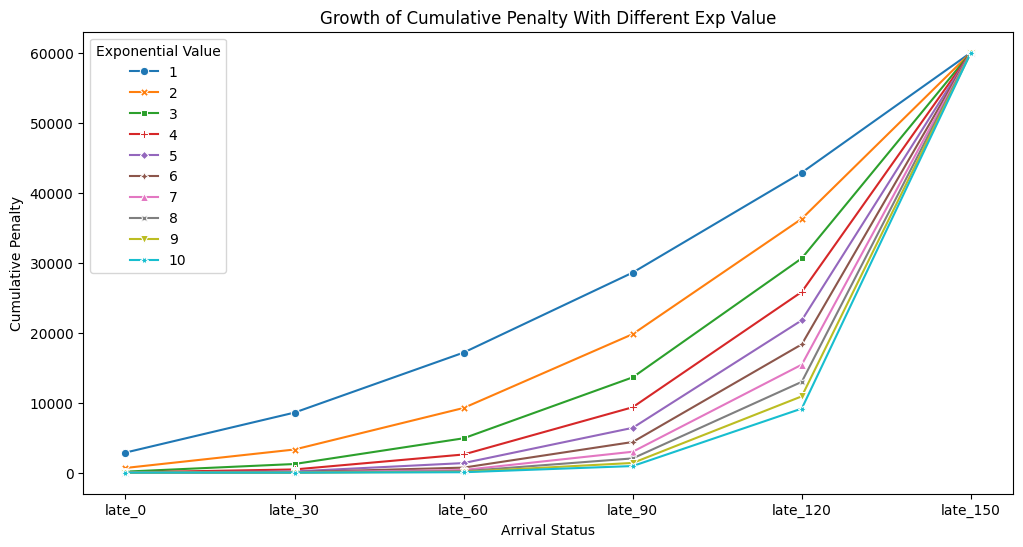

In [104]:
concat_df = pd.concat(dfs)
print(concat_df)

plt.figure(figsize=(12, 6))

#sns.lineplot(data=concat_df, x='arrival_status2', y='Cumulative Penalty', marker='o', ci = None)

sns.lineplot(
    data=concat_df,
    x='arrival_status2',
    y='Cumulative Penalty',
    hue='p',
    style='p',
    markers=True,
    dashes=False,
    palette='tab10',
    legend='brief'
)
plt.title("Growth of Cumulative Penalty With Different Exp Value")
plt.ylabel("Cumulative Penalty")
plt.xlabel("Arrival Status")
plt.legend(title="Exponential Value")


    year     p  mod_total_cost
0   2017  1.00      1445715.29
1   2018  1.00       571429.57
2   2019  1.00       971429.57
3   2021  1.00       162858.14
4   2022  1.00       291429.57
..   ...   ...             ...
65  2019 10.00       269454.27
66  2021 10.00         9509.35
67  2022 10.00       120515.24
68  2023 10.00       201452.27
69  2024 10.00       250382.08

[70 rows x 3 columns]


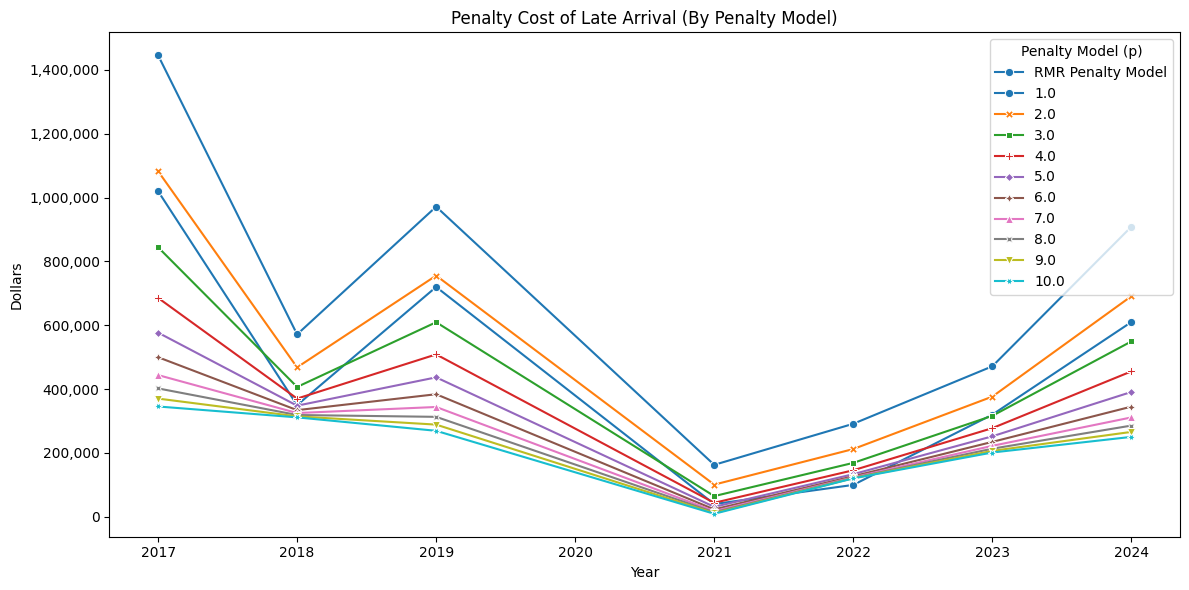

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# First, concatenate all penalty model outputs from your list
# Assuming past_results_by_p is a list of dataframes with columns: ['year', 'mod_total_cost', 'p']
past_penalties_combined = pd.concat(past_results_by_p, ignore_index=True)
print(past_penalties_combined)
# Now plot each distributed penalty model (one line per p)
plt.figure(figsize=(12, 6))

sns.lineplot(data=past_penalties, x='year', y='total_cost', marker='o', label='RMR Penalty Model')

# Use seaborn hue to distinguish different `p` values
sns.lineplot(
    data=past_penalties_combined,
    x='year',
    y='mod_total_cost',
    hue='p',
    style='p',
    markers=True,
    dashes=False,
    palette='tab10',
    legend='brief'
)

# Add title and labels
plt.title("Penalty Cost of Late Arrival (By Penalty Model)")
plt.xlabel("Year")
plt.ylabel("Dollars")

# Format y-axis to avoid scientific notation and use comma separator
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Improve legend
plt.legend(title='Penalty Model (p)', loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_63/4081660367.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


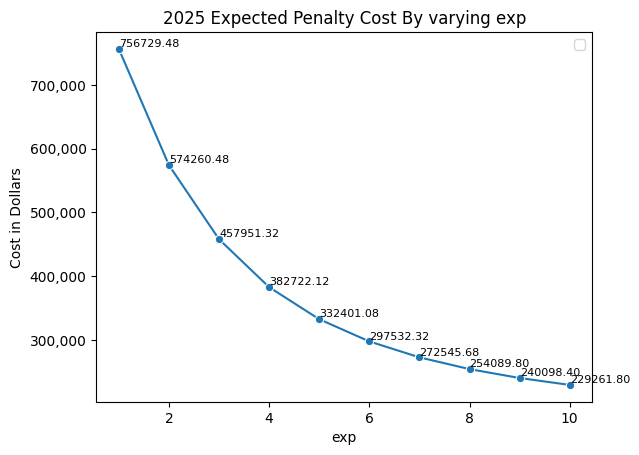

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker  # Import ticker for formatting

sns.lineplot(data=expected_cost_df, x='p', y='expected_cost', marker='o')

# Add title and labels
plt.title("2025 Expected Penalty Cost By varying exp")
plt.xlabel("exp")
plt.ylabel("Cost in Dollars")

# Format y-axis to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Adds comma format with no decimals

for x, y in zip(expected_cost_df['p'], expected_cost_df["expected_cost"]):
    plt.text(x, y, f"{y:.2f}", ha='left', va='bottom', fontsize=8)

plt.legend()
# Show the plot
plt.show()


# 2.4 Model: Hybrid Model Incentives


In [107]:
on_time_df = (arrival_df2
              .loc[arrival_df2['arrival_status2'].isin(['late_30', 'on_time'])]
              .groupby('year')['count'].sum()
              .reset_index(name = 'total')
              
             )
on_time_perc = (
    arrival_df2
    .loc[arrival_df2['arrival_status2'].isin(['late_30', 'on_time'])]
    .loc[ :, ['year', 'arrival_status2', 'count']]
    .merge(on_time_df, on = ['year'], how = 'left')
    .assign(perc = lambda x : x['count'] / x['total'] * 100)
    .loc[ :, ['year', 'arrival_status2', 'count', 'perc']]
)

print(arrival_df2.head(5))
display(on_time_df)
display(on_time_perc)
display(arrival_df2
        .loc[arrival_df2['arrival_status2'].isin(['late_30', 'on_time'])]
        .groupby('year')['percentage'].sum()
        
       )

   year arrival_status2  count  percentage  Penalty   p  Cumulative Penalty  \
0  2017        late_120     10        7.09  5000.00  ~4             5000.00   
1  2017        late_150      4        2.84 10000.00  ~4            10000.00   
2  2017         late_60     22       15.60   500.00  ~4              500.00   
3  2017         late_90     14        9.93  2000.00  ~4             2000.00   
4  2017         on_time     91       64.54     0.00   0                0.00   

   total_penalty  modified_cumu_penalty  modified_total_cost  
0       10000.00                5000.00             50000.00  
1       10000.00               10000.00             40000.00  
2       10000.00                 500.00             11000.00  
3       10000.00                2000.00             28000.00  
4           0.00                   0.00                 0.00  


,year,total
0,2017,91
1,2018,131
2,2019,147
3,2021,29
4,2022,63
5,2023,110
6,2024,101


,year,arrival_status2,count,perc
0,2017,on_time,91,100.00
1,2018,on_time,131,100.00
2,2019,on_time,147,100.00
3,2021,on_time,29,100.00
4,2022,on_time,63,100.00
5,2023,on_time,110,100.00
6,2024,on_time,101,100.00


year
2017   64.54
2018   87.92
2019   82.58
2021   78.38
2022   84.00
2023   88.00
2024   76.52
Name: percentage, dtype: float64